We want to test the models on some chosen stations out of the 45 available.     
The idea is that, for a station, we train a binary classifier which tells whether or not the earthquakes will happen at such station or somewhere else.    
To balance the data, we take N samples from the station, and distribute N samples across the other stations.

In [2]:
import sys
sys.path.append("../../../../..")
from definitions import QUAKES_RAW_DATA_PATH

import os
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random
import math
import networkx as nx
from earthquakes.quakes_util import visualize_quakes, visualize_sensors_graph, read_pickle, write_pickle

In [26]:
NEW_DATASET_FOLDER = os.path.join(QUAKES_RAW_DATA_PATH, "new_dataset_gabriele")
labels = np.load(os.path.join(os.path.join(NEW_DATASET_FOLDER, "packaged", "labels.npy")))


unique_labels = np.unique(labels)
print(f"{labels.shape[0]} samples across {len(unique_labels)} classes")

4633 samples across 45 classes


In [29]:
np.unique(labels, return_counts=True)

(array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.]),
 array([111, 125, 104, 117, 109,  96,  87, 125, 118, 108, 107,  87, 125,
        108,  77, 125,  84, 102, 106,  89,  86, 103,  96,  97, 113, 110,
        110, 103, 117,  98, 105, 106, 116,  88,  56, 100,  88, 108,  98,
        104, 107, 125,  87, 115,  87], dtype=int64))

In [4]:
def get_samples_onevsall_for_class(all_labels, positive_class):
#     print(f"Getting OAA samples for class {positive_class}...")
    assert positive_class in all_labels
    
    
    positive_samples_indices = [idx for idx, label in enumerate(all_labels) if label == positive_class]
    num_of_positive_samples = len(positive_samples_indices)
    
    unique_labels = np.unique(all_labels)
    num_of_classes = len(unique_labels)
    num_of_desired_samples_per_negative_class = math.ceil(num_of_positive_samples/(num_of_classes-1))
    
    negative_samples_indices = []
    for negative_class in [l for l in unique_labels if l != positive_class]:
        neg_class_indices = [idx for idx, label in enumerate(all_labels) if label == negative_class]
        negative_samples_indices += random.sample(neg_class_indices, num_of_desired_samples_per_negative_class)
        
    # assert the indices are not duplicated
    assert len(np.unique(negative_samples_indices)) == len(negative_samples_indices) 
    assert len(np.unique(positive_samples_indices)) == len(positive_samples_indices) 
    
    # assert the intersection between indices is empty
    assert len(set.intersection(set(positive_samples_indices), set(negative_samples_indices))) == 0
    
    assert len(negative_samples_indices) >= len(positive_samples_indices)   
    
    balanced_negative_samples_indices = random.sample(negative_samples_indices, len(positive_samples_indices))
    
    assert len(positive_samples_indices) == len(balanced_negative_samples_indices)

    return positive_samples_indices, balanced_negative_samples_indices
    

# verify the function
pos_idxs, neg_idxs = get_samples_onevsall_for_class(labels, 34)
print(np.take(labels, pos_idxs))
print(np.take(labels, neg_idxs))

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 40.  44.  25.  17.   4.  24.  25.  44.  22.  40.   3.   2.  17.  18.  13.
  28.  11.  33.  11.  28.  31.  17.  34.  41.  35.  15.  12.  24.   4.   8.
   5.  23.  43.  27.   6.  42.  34.  30.  36.  13.  22.  22.  12.  16.  26.
  20.  19.  15.  10.  27.  32.  15.  40.  30.  14.  33.  26.  41.  18.   7.
   3.  11.   9.  21.  35.   0.  31.  10.  37.   2.   8.  29.   5.  38.  43.
  23.  19.  29.  21.   6.   0.   4.   9.  37.  10.  14.  14.   0.  43.  27.
  41.  33.   7.  23.  24.   2.  32. 

### We check which ones are the classes with more samples.

In [32]:
# top_10_classes = Counter(labels).most_common()
# top_10_classes

In [30]:
# pd.DataFrame(top_10_classes, columns=["c_i", "N_i"]).sort_values("N_i", ascending=False).to_latex(index=None)

In [6]:
OAA_dict = {}
for pos_label in unique_labels:
    pos_idxs, neg_idxs = get_samples_onevsall_for_class(labels, pos_label)
    OAA_dict[pos_label] = {
        'pos_indices': pos_idxs,
        'neg_indices': neg_idxs
    }
# write_pickle(OAA_dict, "./OAA_dict.pickle")

# Visualization of chosen station

In [7]:
os.environ["PROJ_LIB"] = "C:\\Users\\gabri\\AppData\\Local\\Continuum\\anaconda3\\pkgs\\proj4-5.2.0-ha925a31_1\\Library\\share";
from mpl_toolkits.basemap import Basemap

bounding_box = [
    166.104, # left lower corner longitude
    178.990, # upper right corner longitude
    -47.749, # left lower corner latitude
    -33.779, # upper right corner latitude
]

nz_basemap = Basemap(
        projection='merc',
        llcrnrlon=bounding_box[0],  # left lower corner longitude
        llcrnrlat=bounding_box[2],  # left lower corner latitude
        urcrnrlon=bounding_box[1],
        urcrnrlat=bounding_box[3],
        lat_ts=0,
        resolution='c',
        suppress_ticks=True)

C:\Users\gabri\AppData\Local\Continuum\anaconda3\envs\tud_ml4se\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


In [8]:
stations_in_bbox = pd.read_csv(os.path.join(NEW_DATASET_FOLDER, "stations_in_bbox.csv"))
weighted_adjacency = np.load(os.path.join(NEW_DATASET_FOLDER, "packaged", "weighted_adjacency.npy"))
class_to_station_dict = read_pickle(os.path.join(NEW_DATASET_FOLDER, "packaged", "class2label_dict.pickle"))



station_lats=list(stations_in_bbox.latitude.values)
station_lons=list(stations_in_bbox.longitude.values)
station_coords = zip(station_lons, station_lats)

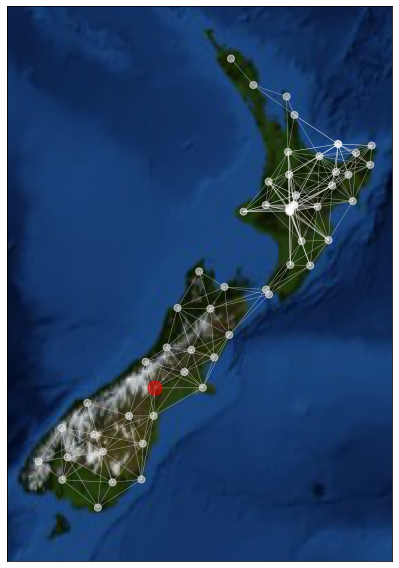

In [38]:
colors = ['white', 'red', 'green', 'yellow']

selected_class = 29
corr_station = class_to_station_dict[selected_class]

nodecolors = ['red' if i == corr_station else 'white' for i, _ in enumerate(station_lons)]
nodesizes = [200 if i == corr_station else 50 for i, _ in enumerate(station_lons)]


plt.figure(figsize=(8, 8))
visualize_sensors_graph(station_lons, station_lats, weighted_adjacency, 
                        nz_basemap, nodesize=nodesizes, nodecolor=nodecolors, 
                        draw_edges=True, edgecolors='white', with_labels=False,
                       alpha=0.5)
plt.tight_layout()
plt.show()